In [60]:
import pandas as pd

# 读取污染物浓度数据（附件1）和气象数据（附件2）
pollution_data = pd.read_excel("附件1：污染物浓度数据.xlsx", engine="openpyxl")
weather_data = pd.read_excel("附件2：气象数据.xlsx", engine="openpyxl")

# # 将质量等级转换为数值型数据（独热编码）
# all_categories = ['优', '良', '轻度污染', '中度污染', '重度污染', '严重污染']
# pollution_data['质量等级'] = pd.Categorical(pollution_data['质量等级'], categories=all_categories)
# pollution_data = pd.concat([pollution_data, pd.get_dummies(pollution_data["质量等级"])], axis=1)
# pollution_data.drop("质量等级", axis=1, inplace=True)

# 合并数据集
merged_data = pollution_data.merge(weather_data, left_on=["年", "月", "日"], right_on=["V04001", "V04002", "V04003"])

# 移除不需要的列
merged_data.drop(["年", "月", "日", "V04001", "V04002", "V04003", "V01301","质量等级","AQI"], axis=1, inplace=True)

# 删除包含缺失值的行
merged_data.dropna(axis=0, inplace=True)



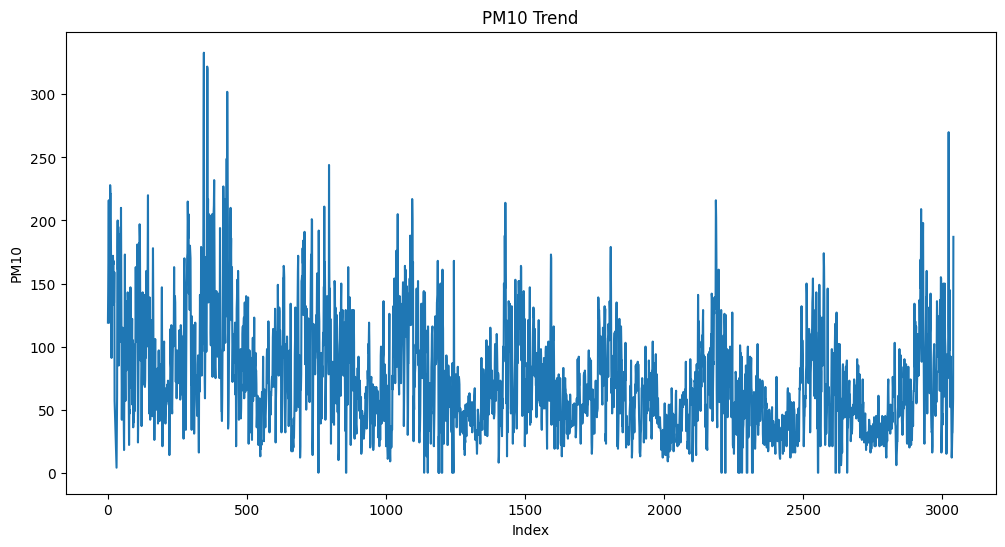

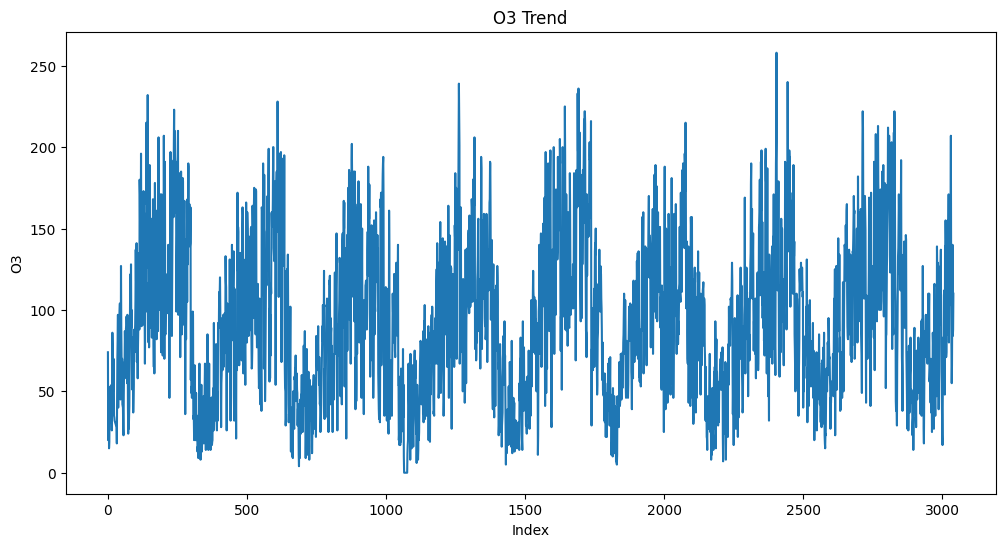

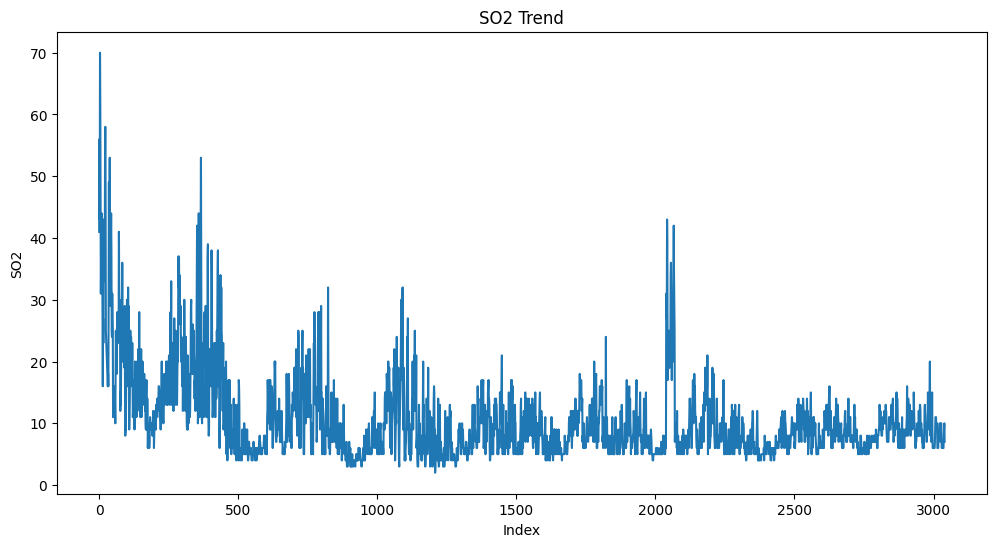

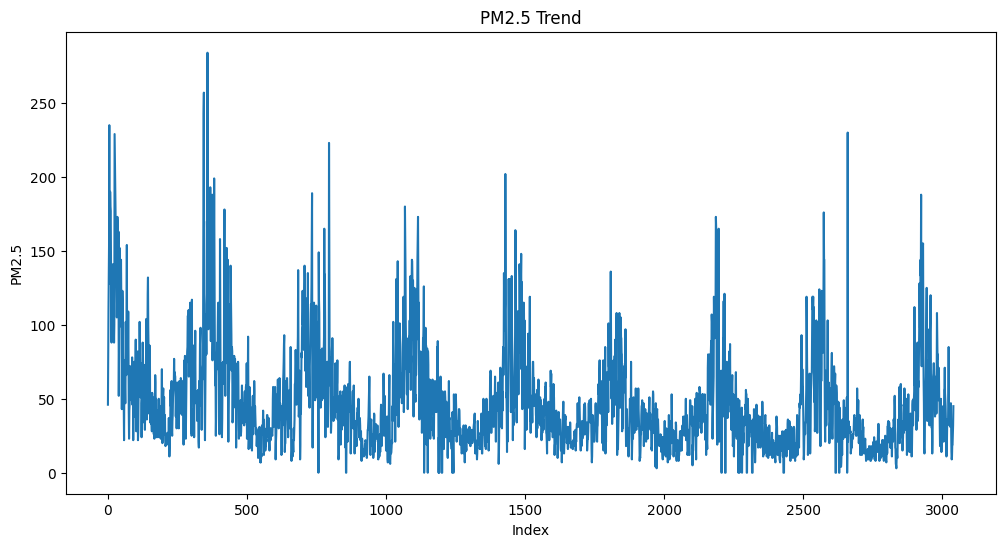

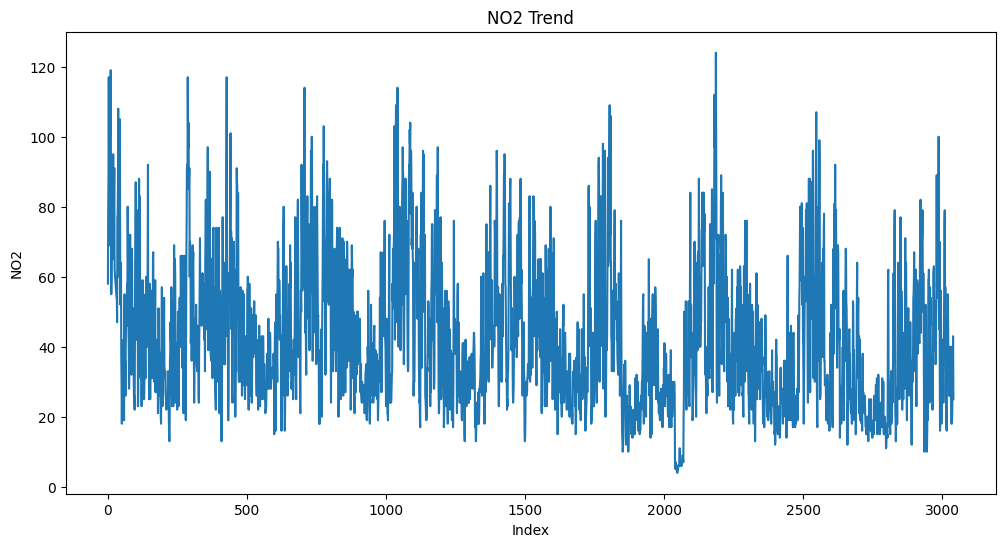

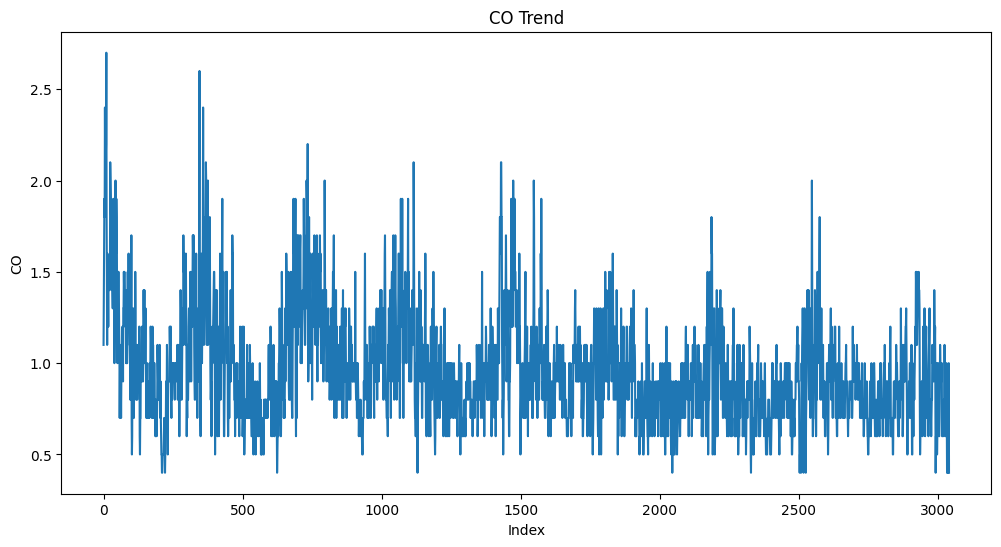

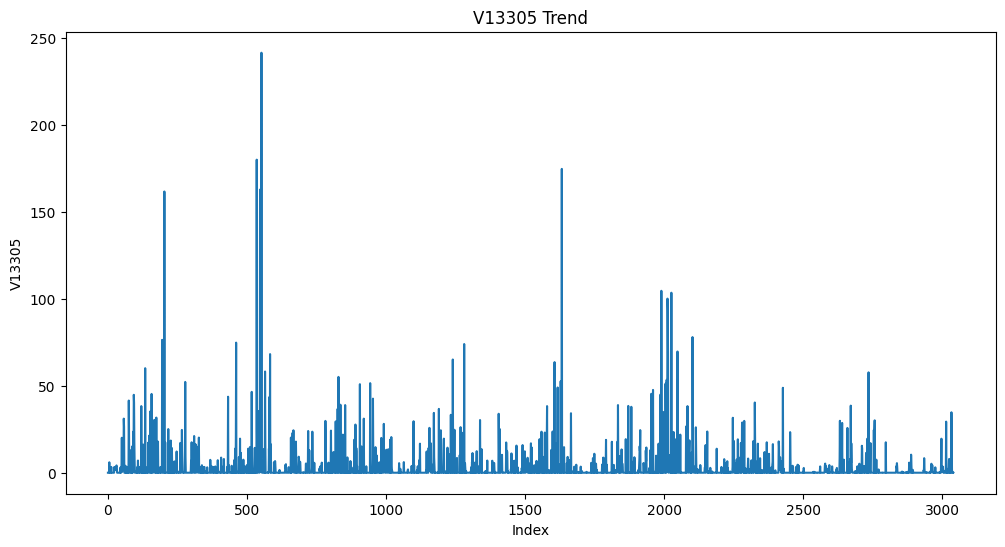

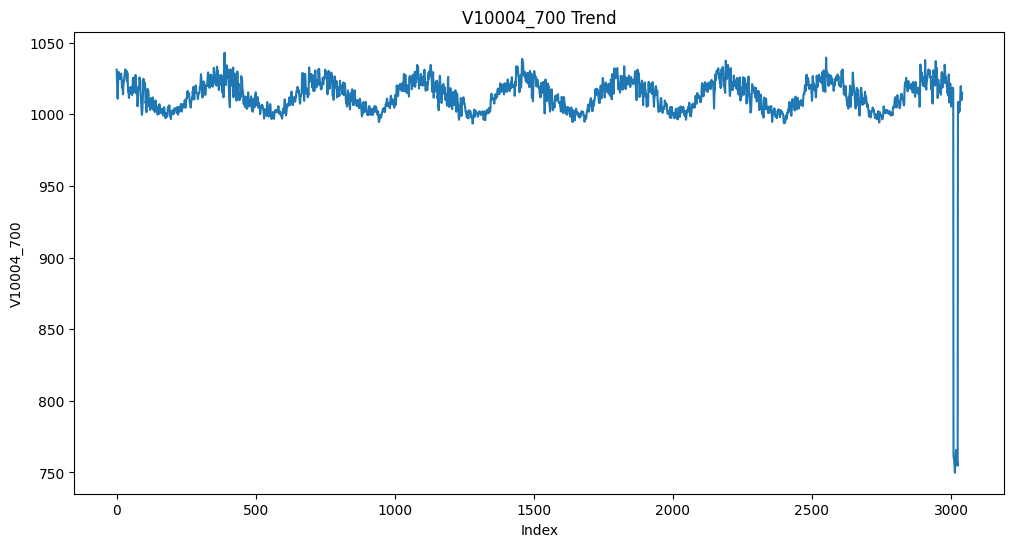

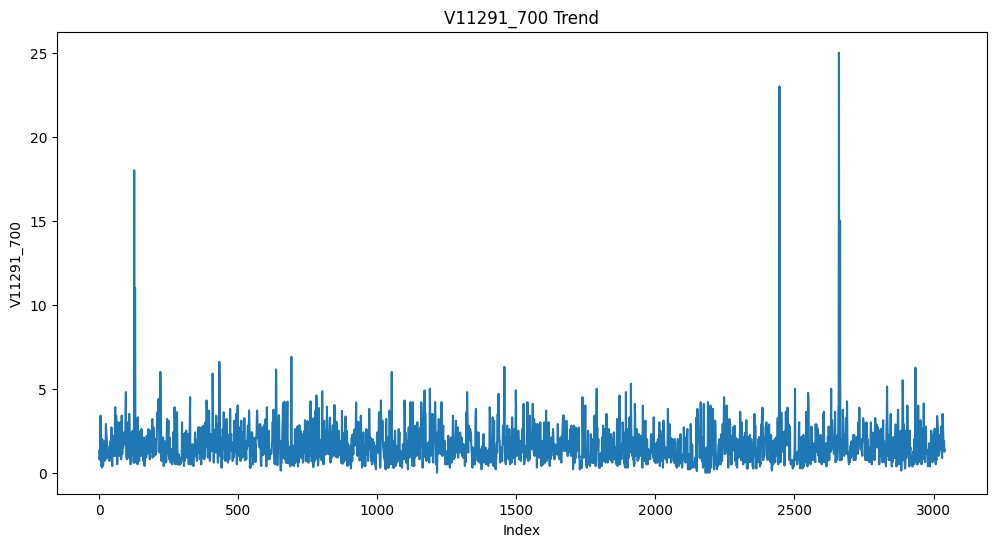

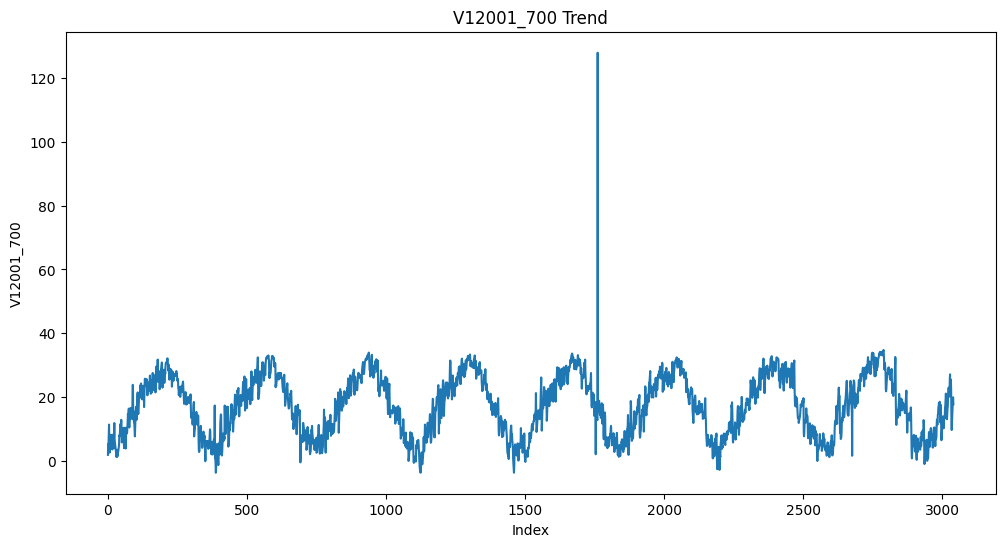

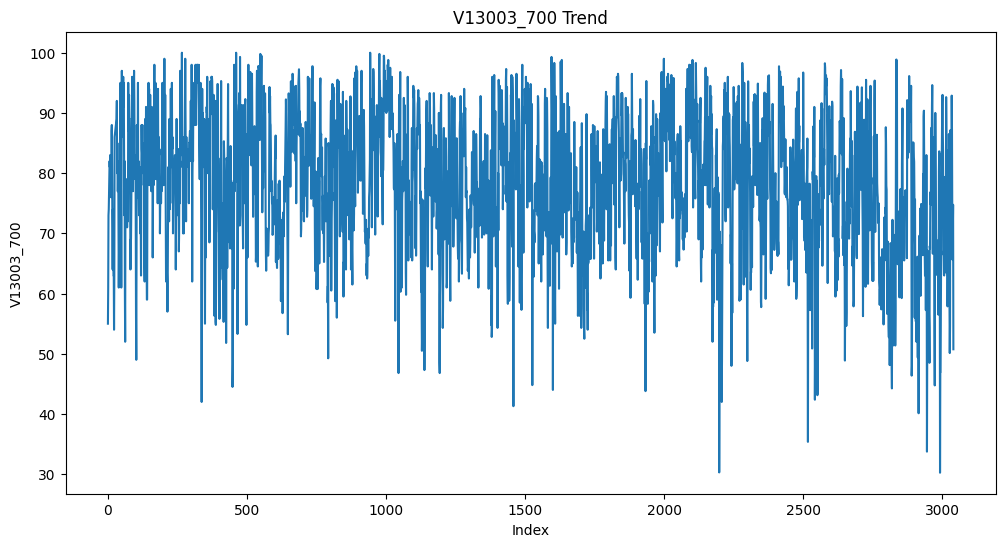

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
# 获取所有列名
column_names = list(merged_data.columns)

# 为每个列绘制趋势图
for column_name in column_names:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=merged_data[column_name])
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'{column_name} Trend')
    plt.show()

In [85]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df > lower_bound) & (df < upper_bound)]

# 移除异常值
merged_data_no_outliers = remove_outliers_iqr(merged_data)

# 将缺失值替换为NaN
merged_data_no_outliers.replace(to_replace={col: {value: np.nan for value in merged_data_no_outliers[col].unique() if pd.isna(value)} for col in merged_data_no_outliers.columns}, inplace=True)

# 使用回归插补填充缺失值
imputer = IterativeImputer(random_state=42, max_iter=50)
imputed_data = imputer.fit_transform(merged_data_no_outliers)

# 将结果转换回DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=merged_data_no_outliers.columns)

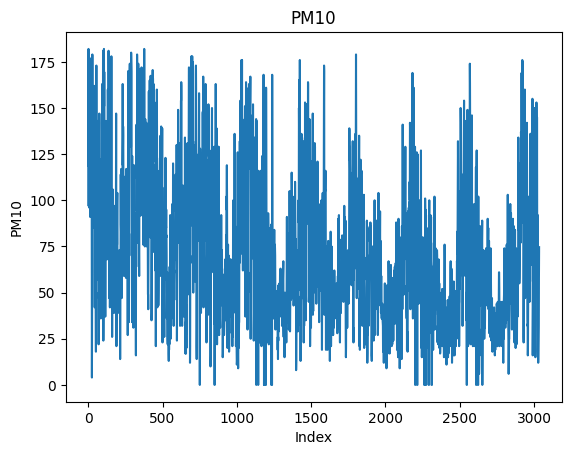

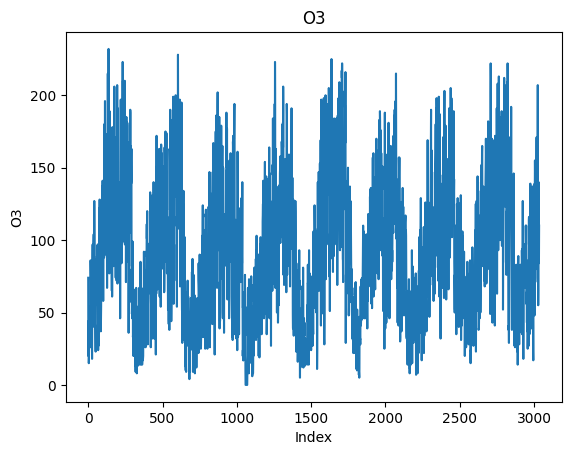

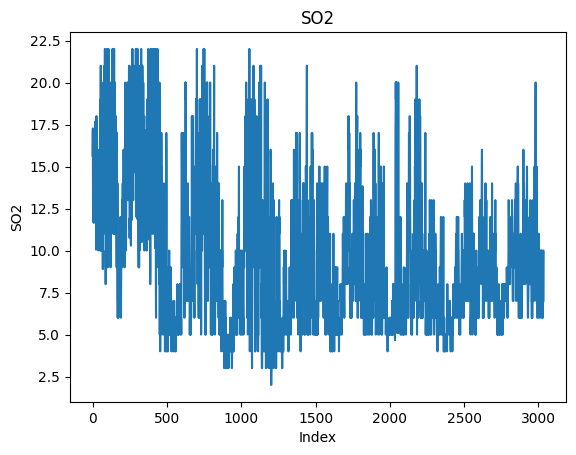

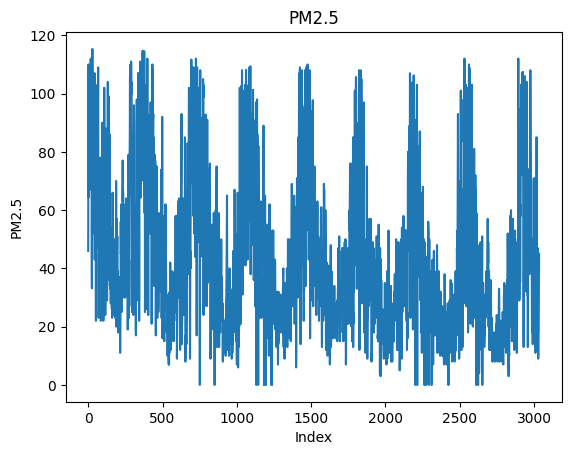

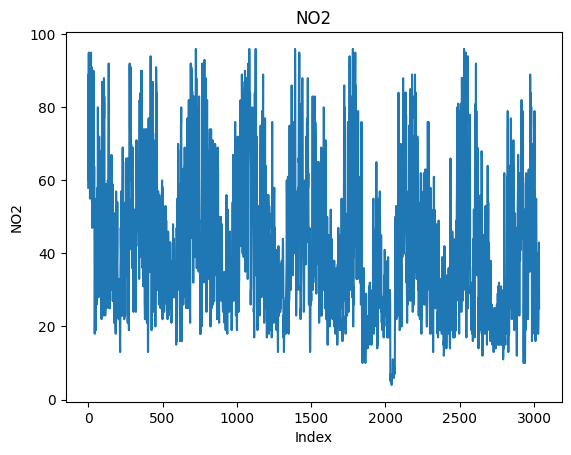

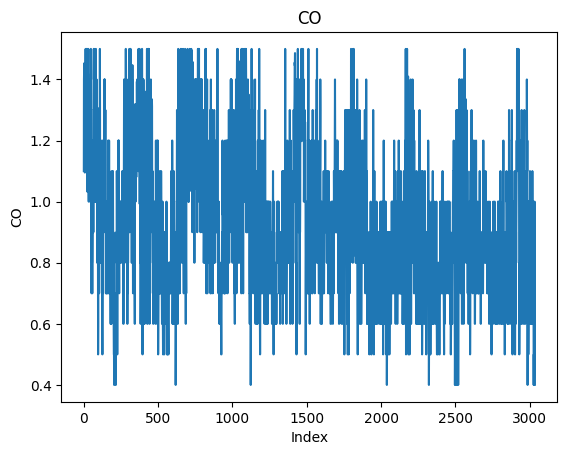

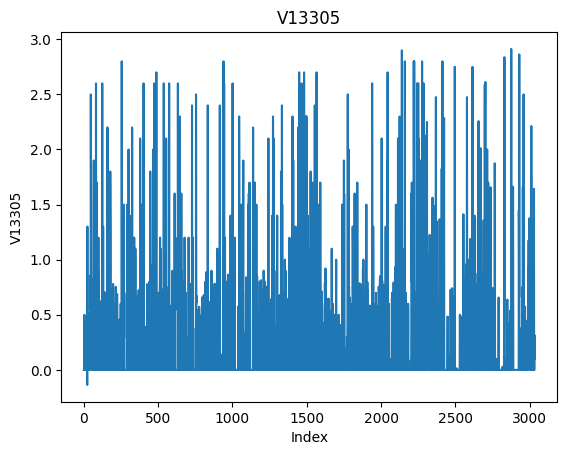

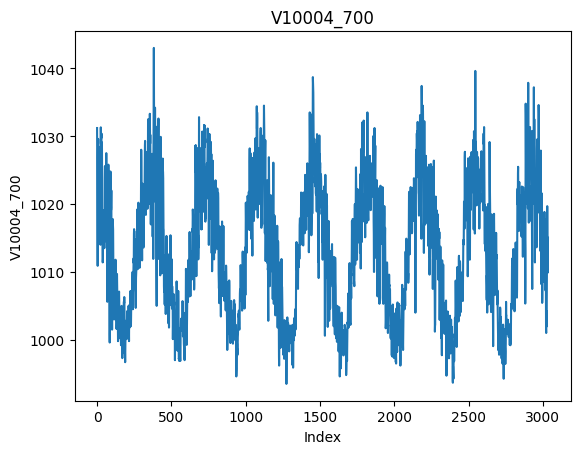

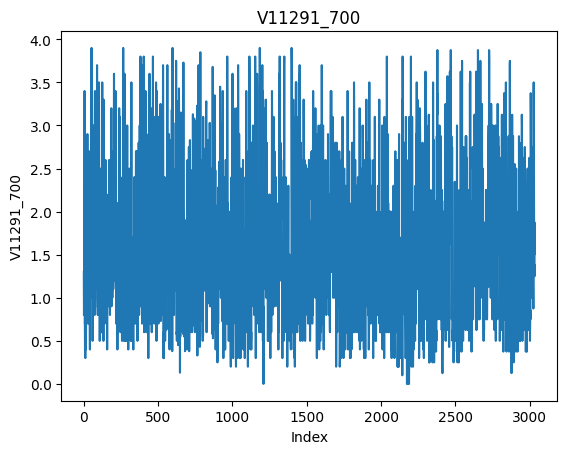

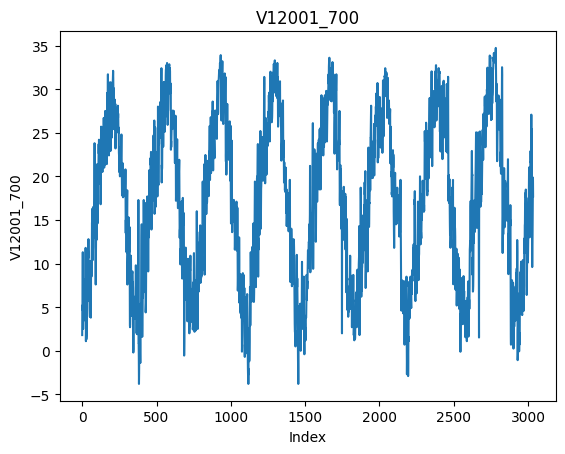

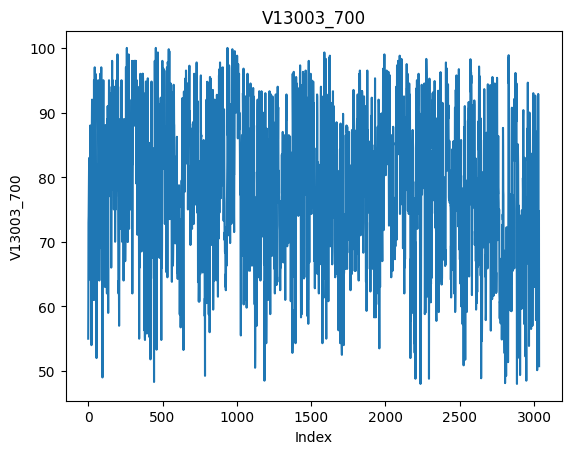

In [86]:
# 绘制各列的趋势图
for column in imputed_data_df.columns:
    plt.figure()
    imputed_data_df[column].plot(title=column)
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.show()

In [87]:
# 划分训练集和测试集
train_data = imputed_data_df.sample(frac=0.8, random_state=1)
test_data = imputed_data_df.drop(train_data.index)

# 保存训练集和测试集到CSV文件
train_data.to_csv("train_data2.csv", index=False, encoding="utf-8")
test_data.to_csv("test_data2.csv", index=False, encoding="utf-8")


In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 特征矩阵X，我们从merged_data中删除PM2.5列
X_train = train_data.drop("PM2.5", axis=1)
# 目标向量y，即PM2.5值
y_train = train_data["PM2.5"]

X_test = test_data.drop("PM2.5", axis=1)
y_test = test_data["PM2.5"]

#创建随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=43)
#训练模型
rf.fit(X_train, y_train)
#使用模型预测测试集
y_pred = rf.predict(X_test)
#计算模型的均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
#输出特征重要性
feature_importances = rf.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")


RMSE: 7.8646280162904985
PM10: 0.7170751136339424
O3: 0.010642103968827426
SO2: 0.012192242587584452
NO2: 0.01565261324415045
CO: 0.10366784480962422
V13305: 0.003714035721401552
V10004_700: 0.012093062501592958
V11291_700: 0.00931527052566726
V12001_700: 0.09772245197300074
V13003_700: 0.01792526103420859


In [75]:
feature_names = list(X_train.columns)

# 获取特征名称和对应的重要性值
feature_importances = list(zip(feature_names, rf.feature_importances_))

# 对特征重要性进行降序排序
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 输出排序后的特征名称和重要性值
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: PM10, Importance: 0.7170751136339424
Feature: CO, Importance: 0.10366784480962422
Feature: V12001_700, Importance: 0.09772245197300074
Feature: V13003_700, Importance: 0.01792526103420859
Feature: NO2, Importance: 0.01565261324415045
Feature: SO2, Importance: 0.012192242587584452
Feature: V10004_700, Importance: 0.012093062501592958
Feature: O3, Importance: 0.010642103968827426
Feature: V11291_700, Importance: 0.00931527052566726
Feature: V13305, Importance: 0.003714035721401552


In [26]:
# 删除 'O3' 和 'V13305' 列
X = merged_data.drop("PM2.5", axis=1)
X = X.drop(['O3', 'V13305','V10004_700','SO2'], axis=1)

from sklearn.model_selection import train_test_split

# 划分数据集，训练集占比为 80%，测试集占比为 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
print(f'Number of features in X_train: {X_train.shape[1]}')

Number of features in X_train: 6


In [43]:
def create_lagged_features(data, n_in=1, n_out=1, dropnan=True):
    """
    创建滞后特征
    :param data: 观测值序列
    :param n_in: 输入滞后观测值的步长
    :param n_out: 输出预测序列的步长
    :param dropnan: 是否删除包含NaN的行
    :return: 返回滞后特征矩阵
    """
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    
    # 输入滞后观测值 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # 输出预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    # 将输入滞后观测值和输出预测序列合并成一个矩阵
    agg = pd.concat(cols, axis=1)
    
    # 删除包含NaN的行
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg.values

n_in = 3
n_out = 1
data = pd.concat([X, y], axis=1)
train_lagged_features = create_lagged_features(X_train, n_in=n_in, n_out=n_out)
test_lagged_features = create_lagged_features(X_test, n_in=n_in, n_out=n_out)
# 分离输入特征和标签
X_train_lagged = train_lagged_features[:, :-n_out]
y_train_lagged = train_lagged_features[:, -n_out]
X_test_lagged = test_lagged_features[:, :-n_out]
y_test_lagged = test_lagged_features[:, -n_out]


In [44]:
print(f'Number of features in X_train_lagged: {X_train_lagged.shape[1]}')
print(f'Number of features in X_train: {X_train.shape[1]}')

Number of features in X_train_lagged: 23
Number of features in X_train: 6


In [45]:
print(X_train_lagged)

[[68.         41.          0.9        ...  1.          2.4
  21.6       ]
 [99.         77.          1.2        ...  0.8         1.1
  22.6       ]
 [42.         26.          0.8        ...  0.9         0.85714286
  16.54285714]
 ...
 [55.         49.          0.7        ...  1.1         2.8
   6.9       ]
 [75.         44.          1.         ...  0.7         1.2
  31.8       ]
 [50.         30.          1.         ...  0.9         1.15
  19.58      ]]


In [46]:
# 使用随机森林回归模型
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

# 使用训练集训练模型
rf_model2.fit(X_train_lagged, y_train_lagged)

# 预测测试集
y_pred_lagged = rf.predict(X_test_lagged)

from sklearn.metrics import mean_squared_error

# 计算 RMSE
rmse_lagged = np.sqrt(mean_squared_error(y_test_lagged, y_pred_lagged))
print(f'RMSE: {rmse_lagged}')


D:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 23 features, but RandomForestRegressor is expecting 10 features as input.